В данном решении рассматривается случай классификации $RGB$ изображений размером $32 \times 32$ на заданное число классов $N\_CLASSES$

На примере с датасетом CIFAR10

# Приготовления

* ### Используемые библиотеки и константы


In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
from IPython import display
import pickle
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

USE_CUDA = True
N_CLASSES = 10
BATCH_SIZE = 128
path_to_data = '../data/'
train_data_file = 'data_train.pickle'
test_data_file = 'data_test_no_labels.pickle'

* ### Класс для закрузки датасета из файл `pickle`

In [2]:
class MyDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
        data = None
        with open(input_path,'rb') as fin:
            data = pickle.load(fin)
        
        self.X = data['data']
        self.y = data['target']
        
        self.X = [Image.fromarray(img) for img in self.X]        
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]

        if self.transform: 
            sample = self.transform(sample)

        return (sample, self.y[idx])

# Загрузка данных

* ### Объявляем набор преобразований для тренировочной и тестовой 

In [3]:
# Image preprocessing modules
train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.ToTensor(),
]
)

* ### Загружаем данные батчами по $128$ Элементов

In [4]:
dataset_train = MyDataset(path_to_data + train_data_file, transform=train_transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

dataset_test = MyDataset(path_to_data + test_data_file, transform=test_transform)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=1)

* ### Отрисовка некоторых изображений

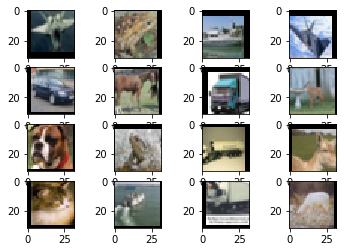

In [5]:
n=4
i=0
for X, y in dataloader_train:
    if i == n * n:
        break
    
    img = X[np.random.randint(0, X.shape[0])].numpy().transpose((1, 2, 0))
    plt.subplot(n,n,i+1)
    plt.imshow(img)
    i += 1

# Построение модели

* ### Основные слои для свёртки и переноса

In [6]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

* ### Объявление блока остаточной сети. Количество выходных каналов зависит от `make_downsample`

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(ResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.make_downsample = make_downsample
        
        if self.make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
        
        a_out_channels = coef * a_in_channels
        self.conv1 = conv3x3(a_in_channels, a_out_channels, a_stride=coef)
        self.bn1 = nn.BatchNorm2d(a_out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(a_out_channels, a_out_channels)
        self.bn2 = nn.BatchNorm2d(a_out_channels)
        self.downsample = x_downsample(a_in_channels)
        self.relu2 = nn.ReLU(inplace=True)
            
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_skip_connection: 
            if self.make_downsample:
                residual = self.downsample(x)
                
            out += residual
            
        out = self.relu2(out)
        return out

* ### Объявление самой нейронной сети

In [8]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 16, layers[1], True)
        self.layer3 = self.make_layer(block, 32, layers[2], True)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, in_channels, blocks, make_downsample=False):
        layers = []
        layers.append(block(in_channels, make_downsample=make_downsample))
        
        out_channels = 2 * in_channels if make_downsample else in_channels
        for i in range(1, blocks):
            layers.append(block(out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

* ### Функции для подсчёта точности на заданных выборках

In [9]:
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

In [38]:
def epoch_accuracy(model, dataloader, device, criterion, optimizer=None):
    accuracy = 0.0
    iters = 0

    for item in dataloader:
        iters += 1
        images = item[0].float()
        labels = item[1].long().squeeze()
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        if optimizer is not None:
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        accuracy += accuracy_score(labels, prediction2classes(outputs))

    return accuracy / iters

* ### Функция обучения нашей нейронной сети

In [39]:
def train_network(net, 
                  device,
                  train_dataloader,
                  test_dataloader,
                  epochs=164,
                  lr=0.1):
    
    train_acc = []
    test_acc  = []
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.0001, momentum=0.9)

    
    for epoch in range(epochs):  # loop over the dataset multiple times
        if epoch == 82:
            optimizer = torch.optim.SGD(net.parameters(), lr=lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 123:
            optimizer = torch.optim.SGD(net.parameters(), lr=lr/100, weight_decay=0.0001, momentum=0.9) 
        
        new_train_acc = epoch_accuracy(net, train_dataloader, device, criterion, optimizer)
        new_test_acc  = epoch_accuracy(net, test_dataloader, device, criterion)
        train_acc.append(new_train_acc)
        test_acc.append(new_test_acc)
        
        plt.figure(figsize=(13, 7))
        plt.title("Epoch number {}/{}".format(epoch+1, epochs))
        plt.plot(train_acc, label="Train accuracy")
        plt.plot(test_acc, label="Test accuracy")
        display.clear_output(wait=True)
        plt.show()

# Обучаем на исходных данных

In [40]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() and USE_CUDA else 'cpu')
net = ResNet(ResidualBlock, [2, 2, 2], N_CLASSES)

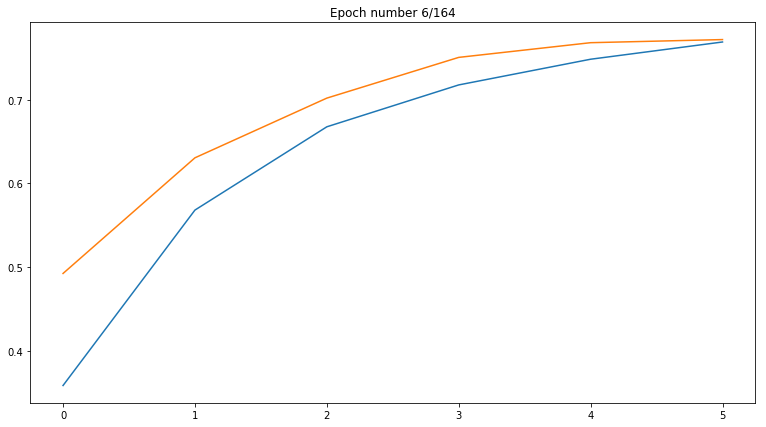

KeyboardInterrupt: 

In [41]:
train_network(net, device, dataloader_train, dataloader_test)